In [1]:

import os, sys, json, random
from collections import Counter
import cv2
import matplotlib.pyplot as plt

BASE = r"C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking"
IMG_TRAIN = os.path.join(BASE, "data", "images", "training")
IMG_VAL   = os.path.join(BASE, "data", "images", "val")
LBL_TRAIN = os.path.join(BASE, "data", "labels", "training")
LBL_VAL   = os.path.join(BASE, "data", "labels", "val")
OUT_YAML  = os.path.join(BASE, "data", "data.yaml")
REPORTS   = os.path.join(BASE, "reports")
os.makedirs(REPORTS, exist_ok=True)

for p in [IMG_TRAIN, LBL_TRAIN]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Path not found: {p}")
print("Paths OK")


Paths OK


In [2]:
def parse_yolo_label_file(path):
    out=[]
    with open(path, "r") as f:
        for line in f:
            parts=line.strip().split()
            if len(parts) >= 5:
                cls = int(float(parts[0]))
                vals = list(map(float, parts[1:5]))
                out.append((cls, *vals))
    return out


In [3]:
train_images = sorted([f for f in os.listdir(IMG_TRAIN) if f.lower().endswith((".jpg",".jpeg",".png"))])
train_labels = sorted([f for f in os.listdir(LBL_TRAIN) if f.lower().endswith(".txt")])
print("Train images:", len(train_images))
print("Train labels:", len(train_labels))

# class counts
counts = Counter()
total_boxes = 0
for lbl in train_labels:
    lblp = os.path.join(LBL_TRAIN, lbl)
    entries = parse_yolo_label_file(lblp)
    total_boxes += len(entries)
    for e in entries:
        counts[e[0]] += 1

print("Total bboxes:", total_boxes)
print("Unique class IDs in training labels:", sorted(list(counts.keys())))
print("Class counts (sorted):", counts.most_common())


Train images: 90
Train labels: 90
Total bboxes: 114
Unique class IDs in training labels: [0, 1, 2, 3, 4, 5, 6]
Class counts (sorted): [(1, 33), (4, 21), (2, 19), (3, 19), (0, 11), (5, 10), (6, 1)]


In [4]:

USE_COCO_NAMES = False

# minimal names as placeholders for each class id present:
unique_ids = sorted(list(counts.keys()))
nc_detected = max(unique_ids) + 1 if unique_ids else 0  # careful: if labels use sparse ids
# If labels use only small set but ids are e.g. [0,5], nc_detected becomes 6. We will compress mapping below.

# compress mapping: map present class ids to 0..k-1
compress = True
if compress:
    id_map = {old:i for i,old in enumerate(unique_ids)}
    # create new labels in new folder if compressing (optional). We'll write a remap routine below.
else:
    id_map = {old:old for old in unique_ids}

print("Detected class IDs:", unique_ids)
print("Will use mapping (old->new):", id_map)


Detected class IDs: [0, 1, 2, 3, 4, 5, 6]
Will use mapping (old->new): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [5]:
REMAPPED_LABEL_DIR = os.path.join(BASE, "data", "labels_remapped", "training")
os.makedirs(REMAPPED_LABEL_DIR, exist_ok=True)
remap = True  # set False to keep original ids

if remap:
    for lbl in train_labels:
        src = os.path.join(LBL_TRAIN, lbl)
        dst = os.path.join(REMAPPED_LABEL_DIR, lbl)
        lines = []
        with open(src, "r") as f:
            for line in f:
                parts=line.strip().split()
                if len(parts) < 5: continue
                old = int(float(parts[0]))
                if old not in id_map:
                    # skip unknown class
                    continue
                new = id_map[old]
                rest = " ".join(parts[1:5])
                lines.append(f"{new} {rest}\n")
        with open(dst, "w") as f:
            f.writelines(lines)
    print("Remapped labels written to:", REMAPPED_LABEL_DIR)
    LBL_TRAIN_USED = REMAPPED_LABEL_DIR
else:
    LBL_TRAIN_USED = LBL_TRAIN


Remapped labels written to: C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\labels_remapped\training


In [6]:
if USE_COCO_NAMES:
    # Full COCO80 list
    COCO80 = [
      'person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','traffic light',
      'fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow',
      'elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
      'skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard',
      'tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich',
      'orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant','bed',
      'dining table','toilet','TV','laptop','mouse','remote','keyboard','cell phone','microwave','oven',
      'toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush'
    ]
    # If compressing, keep only those classes present
    if compress:
        names = [COCO80[old] for old in unique_ids]
    else:
        names = COCO80
else:
    # build simple placeholders in order of mapping
    names = [f"class_{i}" for i in range(len(unique_ids))]

print("Final names list (first 20):", names[:20])


Final names list (first 20): ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']


In [7]:
# Note: images are not moved; only labels are remapped. We point train labels via images path.
train_images_path = IMG_TRAIN.replace("\\","/")
val_images_path = IMG_VAL.replace("\\","/")  # ensure val exists; if not create and split later

# Determine nc
nc = len(names)

data_yaml_content = f"train: {train_images_path}\nval: {val_images_path}\n\nnc: {nc}\nnames: {names}\n"
with open(OUT_YAML, "w") as f:
    f.write(data_yaml_content)

print("Wrote data.yaml to:", OUT_YAML)
print(data_yaml_content)


Wrote data.yaml to: C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\data.yaml
train: C:/Users/ksush/Downloads/Summer_intern/Real_time_object_detection_tracking/data/images/training
val: C:/Users/ksush/Downloads/Summer_intern/Real_time_object_detection_tracking/data/images/val

nc: 7
names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']



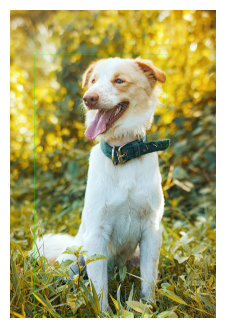

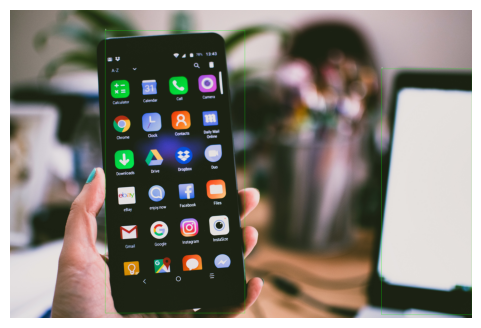

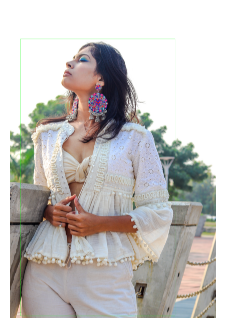

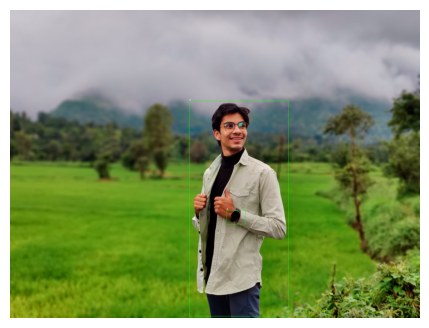

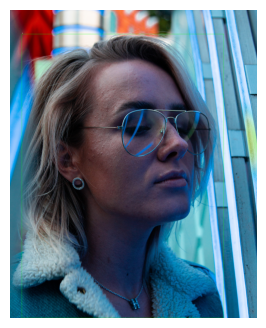

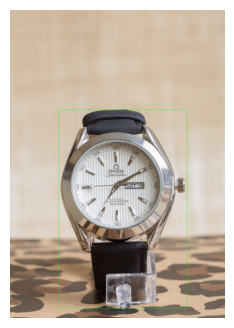

In [8]:
sample_imgs = random.sample(train_images, min(6,len(train_images)))
for imgf in sample_imgs:
    imgp = os.path.join(IMG_TRAIN, imgf)
    lblp = os.path.join(LBL_TRAIN_USED, os.path.splitext(imgf)[0] + ".txt")
    img = cv2.imread(imgp)
    if img is None:
        continue
    h,w = img.shape[:2]
    if os.path.exists(lblp):
        with open(lblp,"r") as f:
            for line in f:
                parts=line.strip().split()
                if len(parts) < 5: continue
                cls = int(parts[0]); xc, yc, ww, hh = map(float, parts[1:5])
                x1 = int((xc - ww/2) * w); y1 = int((yc - hh/2) * h)
                x2 = int((xc + ww/2) * w); y2 = int((yc + hh/2) * h)
                cv2.rectangle(img, (x1,y1),(x2,y2), (0,255,0), 2)
                cv2.putText(img, str(cls), (x1, max(y1-6,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4)); plt.imshow(img_rgb); plt.axis("off")
plt.show()


✅ Dataset Folders:
Train Images: C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\images\training
Val Images: C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\images\val

✅ YAML Configuration:
{'train': 'C:/Users/ksush/Downloads/Summer_intern/Real_time_object_detection_tracking/data/images/training', 'val': 'C:/Users/ksush/Downloads/Summer_intern/Real_time_object_detection_tracking/data/images/val', 'nc': 4, 'names': ['person', 'bottle', 'cell phone', 'spoon']}

Total train images: 90
Total val images: 17


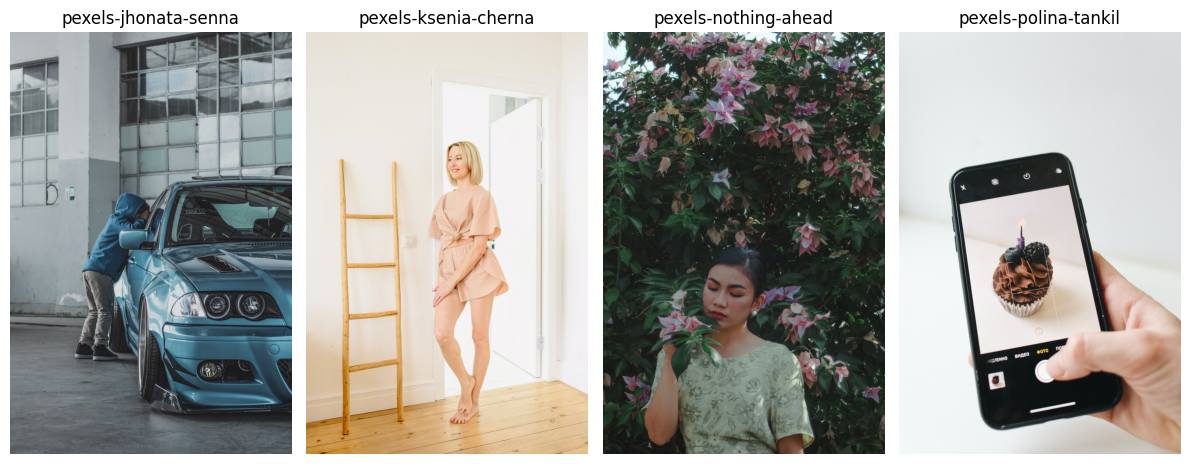

In [3]:
# ============================================================
# 01_EDA_dataprep.ipynb
# Purpose: Inspect dataset, visualize samples, check labels
# ============================================================

import os
import cv2
import random
import matplotlib.pyplot as plt
import yaml

BASE = r"C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking"
train_dir = os.path.join(BASE, "data", "images", "training")
val_dir = os.path.join(BASE, "data", "images", "val")
yaml_path = os.path.join(BASE, "data", "data.yaml")

print("✅ Dataset Folders:")
print("Train Images:", train_dir)
print("Val Images:", val_dir)

# --- Check YAML content ---
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
print("\n✅ YAML Configuration:")
print(data_yaml)

# --- Count files ---
def count_files(folder):
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

train_count = count_files(train_dir)
val_count = count_files(val_dir)
print(f"\nTotal train images: {train_count}")
print(f"Total val images: {val_count}")

# --- Show random samples ---
def show_random_images(img_dir, n=4):
    # List only valid image files
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')
    imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(valid_ext)]

    if len(imgs) == 0:
        raise FileNotFoundError(f"No valid images found in: {img_dir}")

    sample_imgs = random.sample(imgs, min(n, len(imgs)))
    plt.figure(figsize=(12, 6))

    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(img_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"⚠️ Skipping unreadable file: {img_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(img_name[:20])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Test again
show_random_images(train_dir)

In [4]:
print("Train dir exists:", os.path.exists(train_dir))
print("Files in train_dir:", os.listdir(train_dir)[:10])

Train dir exists: True
Files in train_dir: ['pexels-akshay-mehra-10568782.jpg', 'pexels-aleks-magnusson-2907762.jpg', 'pexels-alexander-hamilton-9443581.jpg', 'pexels-ali-dashti-16924358.jpg', 'pexels-ali-pazani-2975612.jpg', 'pexels-ali-pazani-3061814.jpg', 'pexels-alican-helik-18052763.jpg', 'pexels-alimurat-üral-16896947.jpg', 'pexels-alina-komarevska-15793245.jpg', 'pexels-ana-ferreira-1895976.jpg']


In [5]:
# -----------------------------
# 01_EDA_dataprep.ipynb
# -----------------------------

# Imports
import os
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# -----------------------------
# Dataset Paths (update here)
# -----------------------------
train_dir = r"C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\images\training"
val_dir   = r"C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\images\val"
data_yaml = r"C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\data.yaml"

# -----------------------------
# Verify folders
# -----------------------------
print("Train dir exists:", os.path.exists(train_dir))
print("Files in train_dir:", os.listdir(train_dir)[:10])

with open(data_yaml, 'r') as f:
    data_cfg = yaml.safe_load(f)

print("\n✅ Dataset Folders:")
print(f"Train Images: {train_dir}")
print(f"Val Images:   {val_dir}")
print("\n✅ YAML Configuration:")
print(data_cfg)


Train dir exists: True
Files in train_dir: ['pexels-akshay-mehra-10568782.jpg', 'pexels-aleks-magnusson-2907762.jpg', 'pexels-alexander-hamilton-9443581.jpg', 'pexels-ali-dashti-16924358.jpg', 'pexels-ali-pazani-2975612.jpg', 'pexels-ali-pazani-3061814.jpg', 'pexels-alican-helik-18052763.jpg', 'pexels-alimurat-üral-16896947.jpg', 'pexels-alina-komarevska-15793245.jpg', 'pexels-ana-ferreira-1895976.jpg']

✅ Dataset Folders:
Train Images: C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\images\training
Val Images:   C:\Users\ksush\Downloads\Summer_intern\Real_time_object_detection_tracking\data\images\val

✅ YAML Configuration:
{'train': 'C:/Users/ksush/Downloads/Summer_intern/Real_time_object_detection_tracking/data/images/training', 'val': 'C:/Users/ksush/Downloads/Summer_intern/Real_time_object_detection_tracking/data/images/val', 'nc': 4, 'names': ['person', 'bottle', 'cell phone', 'spoon']}


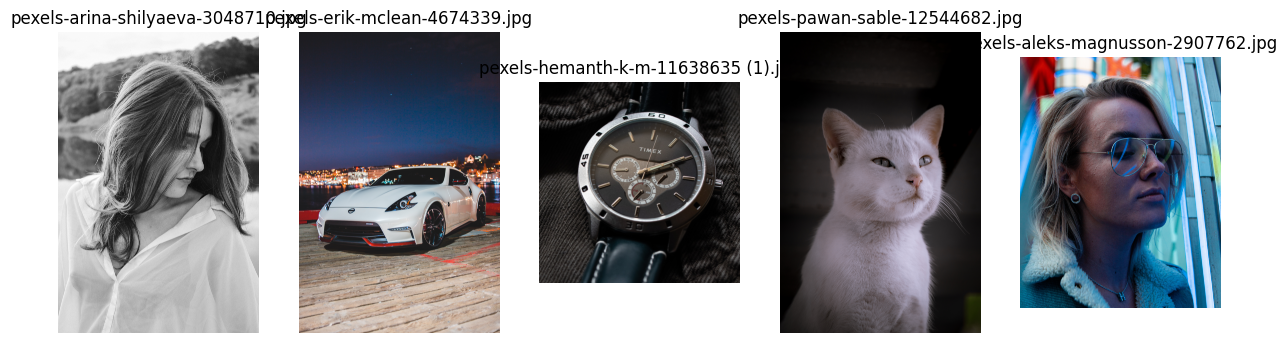

In [6]:
def show_random_images(img_dir, n=5):
    imgs = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    imgs = random.sample(imgs, min(n, len(imgs)))
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(imgs):
        image = cv2.imread(os.path.join(img_dir, img))
        if image is None:
            print(f"⚠️ Could not read: {img}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(img)
        plt.axis('off')
    plt.show()

show_random_images(train_dir)
